In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import netCDF4 as nc
import numpy as np
import re
import datetime
from matplotlib.ticker import FixedLocator
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
#mpld3.enable_notebook()
import site
import importlib
import plot_settings
import os
import matplotlib.gridspec as gridspec
#from lib.plot       import mc_set_outtype, mc_set_matplotlib, mc_plot_begin, mc_plot_save, mc_plot_end

In [45]:

tstep = 1800 # site data time step
sitename='CumberlandPlain'

CABLE_SITE_fname1 = '/Users/hav014/Data/BIOS3/190222/Cumberland_POP_CNP_out_cable.nc'
CABLE_SITE_fname2 = '/Users/hav014/Data/BIOS3/190222/Cumberland_POP_CNP_out_cable_opt_LAIv_AWAP_forcing_2014_2017.nc'
#CABLE_SITE_fname2 = '/Users/hav014/Data/BIOS3/190222/Cumberland_POP_CNP_out_cable_opt_LAIv.nc'
#CABLE_SITE_fname2 = '/Users/hav014/Data/BIOS3/190222/Cumberland_HowSprParams_LAIv_CNP_out_cable.nc'

plot_dir = '/Users/hav014/Data/BIOS3/190222/'
plot_fname = 'Cumb_two_param_sets.pdf'
plot_fname1 = 'Cumb_NEP_site_met_190222.pdf'
plot_fname_Evap = 'Cumb_Evap_site_met_190222.pdf'
plot_fname_GPP = 'Cumb_GPP_site_met_190222.pdf'

In [46]:
importlib.reload(site)
df1=site.read_cable_single_site(CABLE_SITE_fname1)
df2=site.read_cable_single_site(CABLE_SITE_fname2)

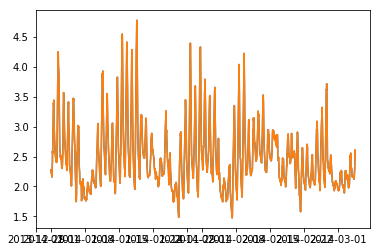

In [6]:
# plot first four days
vars = ['LWdown','SWdown','Tair','Qair','Wind','ESoil','TVeg','LAI','GPP','VegT','Fwsoil']
plt.plot(df1['vpd'][:200*15])
plt.plot(df2['vpd'][:200*15])

In [15]:
#importlib.reload(site)
df_obs=site.read_ozflux(sitename,tstep)

In [36]:
# get Trfs
Tref = df1['Tair'].mean()
q10 = 2
df1['Trf_Ta_h'] = site.Q10(df1['Tair'],Tref,q10)
df1['Trf_Ta_d'] = site.Q10(df1['TairDailyMean'],Tref,q10)

df1['Trf_Tsoil_h']= site.Q10(df1['SoilTemp1'],Tref,q10)
df1['Trf_Tsoil_d']=site.Q10(df1['SoilTemp1DailyMean'],Tref,q10)

grouped = df1.groupby('day')
df1 = grouped.apply(site.compute_mean_Trf) # gives us df['Daily_Mean_Trf; Daily_Mean_Trf_Tsoil'] 

df1['Ta_bar'] = 10 * np.log(df1['Daily_Mean_Trf_Ta'].values)/np.log(q10) + Tref
df1['Trf_Ta_bar'] = site.Q10(df1['Ta_bar'],Tref,q10)

df1['Tsoil_bar'] = 10 * np.log(df1['Daily_Mean_Trf_Tsoil'].values)/np.log(q10) + Tref
df1['Trf_Tsoil_bar']=site.Q10(df1['Tsoil_bar'],Tref,q10)


In [37]:
# create diurnal T response function by which to correct ecosystem respiration
df1['Trf_Ta_norm'] = df1['Trf_Ta_h'][:] / df1['Trf_Ta_bar'][:]
df1['Trf_Tsoil_norm'] = df1['Trf_Tsoil_h'][:] / df1['Trf_Tsoil_bar'][:]
x = df1.index
#plt.plot(x,df['Trf_Tsoil_norm'])
#plt.plot(x,df['Trf_Ta_norm'])

In [47]:
# construct diurnal cycle by season
dfs1=[]
dfs2=[]
for i in range(4):
    dfs1.append(df1[df1['season']==i+1].groupby(lambda x: x.hour).mean())
    dfs2.append(df2[df2['season']==i+1].groupby(lambda x: x.hour).mean())

24

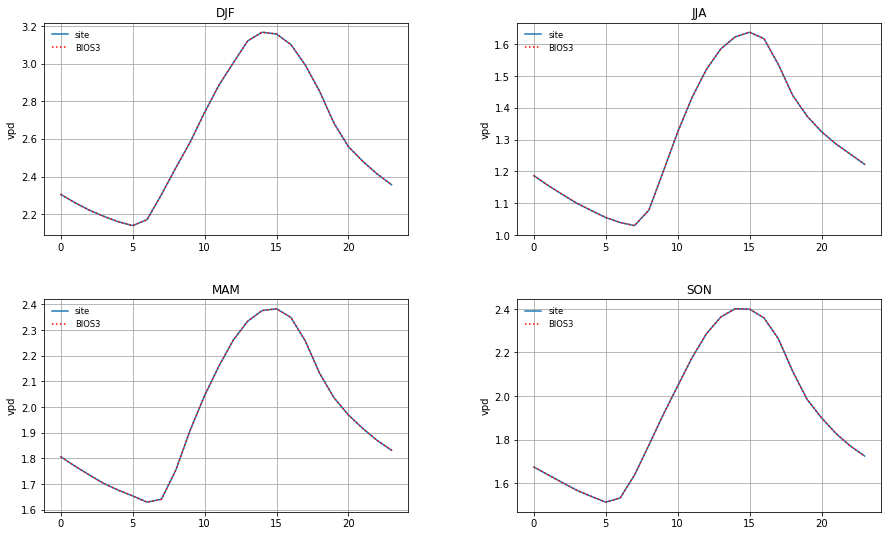

In [39]:
# compare diurnal cycle of given variable
var = 'vpd'
fig=plt.figure(figsize=(15, 9))
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
x1 = dfs1[1].index
x2 = dfs2[1].index
sindex=[(0,0),(1,0),(0,1),(1,1)]
slabel = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(4):
    ax = plt.subplot2grid((2,2),sindex[i])
    y1 = dfs1[i][var] 
    y2 = dfs2[i][var]
    plt.plot(x1,y1,label="site")
    plt.plot(x2,y2,label="BIOS3", linestyle=':',color = 'red')
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize='small',frameon=False,loc=2)
    ax.set_ylabel(var)
    ax.set_title(slabel[i])
    
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
y2.size

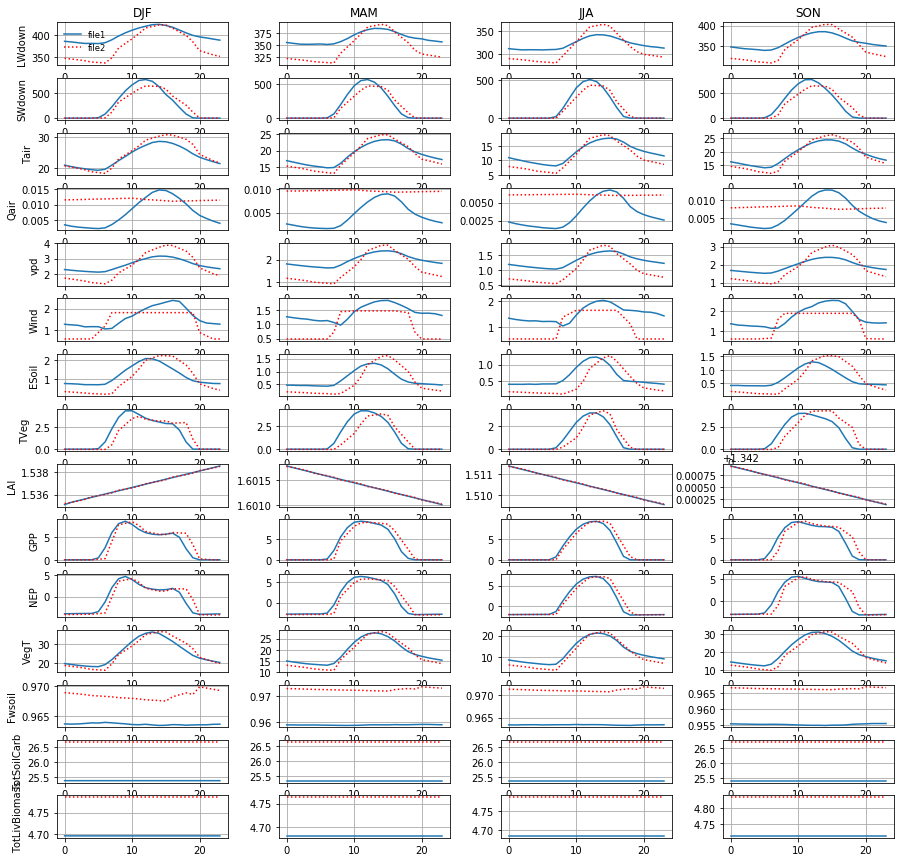

In [49]:
vars = ['LWdown','SWdown','Tair','Qair','vpd','Wind','ESoil','TVeg','LAI','GPP','NEP','VegT','Fwsoil','TotSoilCarb','TotLivBiomass']
fig=plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
slabel = ['DJF', 'MAM', 'JJA', 'SON']
x1 = dfs1[1].index
x2 = dfs2[1].index
nv = len(vars)
for index, v in enumerate(vars):
    sindex = [(index,0),(index,1),(index,2),(index,3)]
    for i in range(4):
        ax = plt.subplot2grid((nv,4),sindex[i])
        y1 = dfs1[i][vars[index]]
        y2 = dfs2[i][vars[index]]
        plt.plot(x1,y1,label="file1")
        plt.plot(x2,y2,label="file2", linestyle=':',color = 'red')
        plt.grid(b=True, which='both', color='0.65', linestyle='-')      
        if i==0:
            ax.set_ylabel(vars[index])
        if index==0:
            ax.set_title(slabel[i])
        if index==0 and i==0:
            plt.legend(fontsize='small',frameon=False,loc=2)
fig.subplots_adjust(hspace=0.3, wspace = 0.3)

In [11]:


fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

24

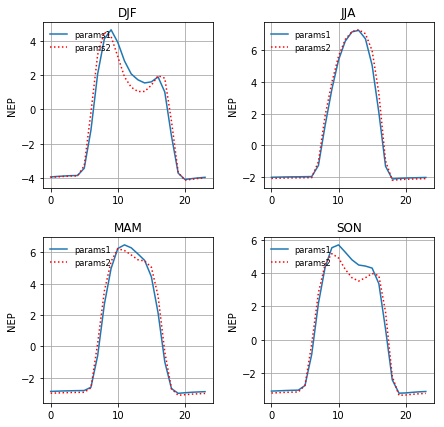

In [14]:
# compare diurnal cycle of given variable
var = 'NEP'
fig=plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
x1 = dfs1[1].index
x2 = dfs2[1].index
sindex=[(0,0),(1,0),(0,1),(1,1)]
slabel = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(4):
    ax = plt.subplot2grid((2,2),sindex[i])
    y1 = dfs1[i][var] 
    y2 = dfs2[i][var]
    plt.plot(x1,y1,label="params1")
    plt.plot(x2,y2,label="params2", linestyle=':',color = 'red')
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize='small',frameon=False,loc=2)
    ax.set_ylabel(var)
    ax.set_title(slabel[i])
    
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
y2.size

In [16]:
dfobs=[]
for i in range(4):
    dfobs.append(df_obs[df_obs['season']==i+1].groupby(lambda x: x.hour).mean())

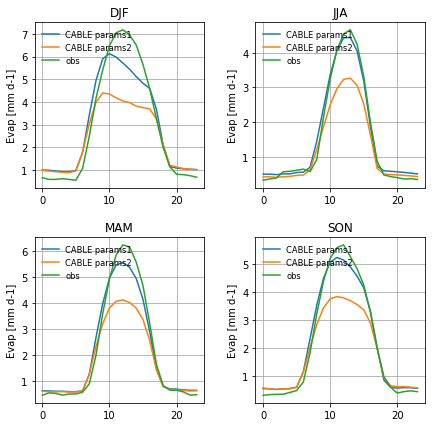

In [17]:
fig=plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
x = dfs1[1].index
x1 = dfobs[1].index
sindex=[(0,0),(1,0),(0,1),(1,1)]
slabel = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(4):
    ax = plt.subplot2grid((2,2),sindex[i])
    y1 = dfs1[i]['Evap']
    y2 = dfs2[i]['Evap']
    y3 = dfobs[i]['Evap']
    plt.plot(x,y1,label="CABLE params1")
    plt.plot(x,y2,label="CABLE params2")
    plt.plot(x1,y3,label="obs")
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize='small',frameon=False,loc=2)
    ax.set_ylabel('Evap [mm d-1]')
    ax.set_title(slabel[i])
    
fig.subplots_adjust(hspace=0.3, wspace = 0.3)

In [18]:
fig.savefig(os.path.join(plot_dir, plot_fname_Evap), bbox_inches='tight',
                    pad_inches=0.1)

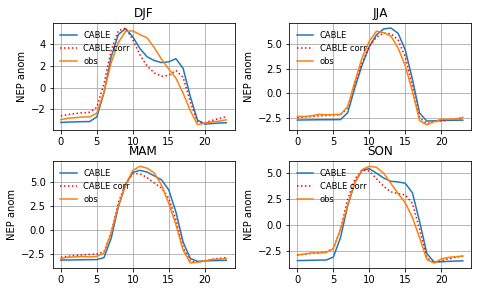

In [22]:
fig=plt.figure(figsize=(7.5, 4.5))
fig.subplots_adjust(hspace=0.3, wspace = 0.3)
x = dfs1[1].index
x1 = dfobs[1].index
sindex=[(0,0),(1,0),(0,1),(1,1)]
slabel = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(4):
    ax = plt.subplot2grid((2,2),sindex[i])
    y1 = dfs1[i]['NEP'] - dfs1[i]['NEP'].mean()
    y2 = dfs1[i]['GPP'] - (dfs1[i]['HeteroResp'][:]*dfs1[i]['Trf_Ta_norm'][:])- \
    ((dfs1[i]['AutoResp'][:] -dfs1[i]['LeafResp']) *dfs1[i]['Trf_Ta_norm'][:]) - dfs1[i]['LeafResp'][:]
    y2 = y2 - y2.mean()
    y3 = dfobs[i]['NEP']-dfobs[i]['NEP'].mean()
    y3 = y3 - y3.mean()
    plt.plot(x,y1,label="CABLE")
    plt.plot(x,y2,label="CABLE corr", linestyle=':',color = 'red')
    plt.plot(x1,y3,label="obs")
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize='small',frameon=False,loc=2)
    ax.set_ylabel('NEP anom')
    ax.set_title(slabel[i])
    
fig.subplots_adjust(hspace=0.3, wspace = 0.3)

In [23]:
fig.savefig(os.path.join(plot_dir, plot_fname1), bbox_inches='tight',
                    pad_inches=0.1)

39.999504
37.159813
37.914143
37.12899
31.426895
31.303246
42.547363
40.134632


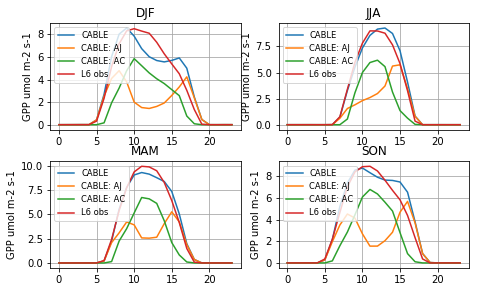

In [24]:
fig=plt.figure(figsize=(7.5, 4.5))
fig.subplots_adjust(hspace=0.3, wspace = 0.1)
x = dfs1[1].index
x1 = dfobs[1].index
sindex = [(0,0),(1,0),(0,1),(1,1)]
slabel = ['DJF', 'MAM', 'JJA', 'SON']
var = 'GPP'
units = 'umol m-2 s-1'
for i in range(4):
    ax = plt.subplot2grid((2,2),sindex[i])
    y1 = dfs1[i][var] 
    y3 = dfobs[i][var]
    y2 = dfs1[i]['GPP_sunlit_J'] + dfs1[i]['GPP_shaded_J']
    y2a = dfs1[i]['GPP_sunlit_C'] + dfs1[i]['GPP_shaded_C']
    print(y2a.sum())
    print(y2.sum())
    #y2=dfs[i]['GPP']
    plt.plot(x,y1,label="CABLE")
    plt.plot(x,y2,label="CABLE: AJ ")
    plt.plot(x,y2a,label="CABLE: AC")
    plt.plot(x1,y3,label="L6 obs")
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    plt.legend(fontsize='small',frameon=True,loc=2)
    ax.set_ylabel(var+' '+units)
    ax.set_title(slabel[i])
    
fig.subplots_adjust(hspace=0.3, wspace = 0.2)
fig.savefig(os.path.join(plot_dir, plot_fname_GPP), bbox_inches='tight',
                    pad_inches=0.1)

In [26]:
# construct annual cycle by month
dfm1 = df1.groupby(lambda x: x.month).mean()
dfobsm = df_obs.groupby(lambda x: x.month).mean()

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


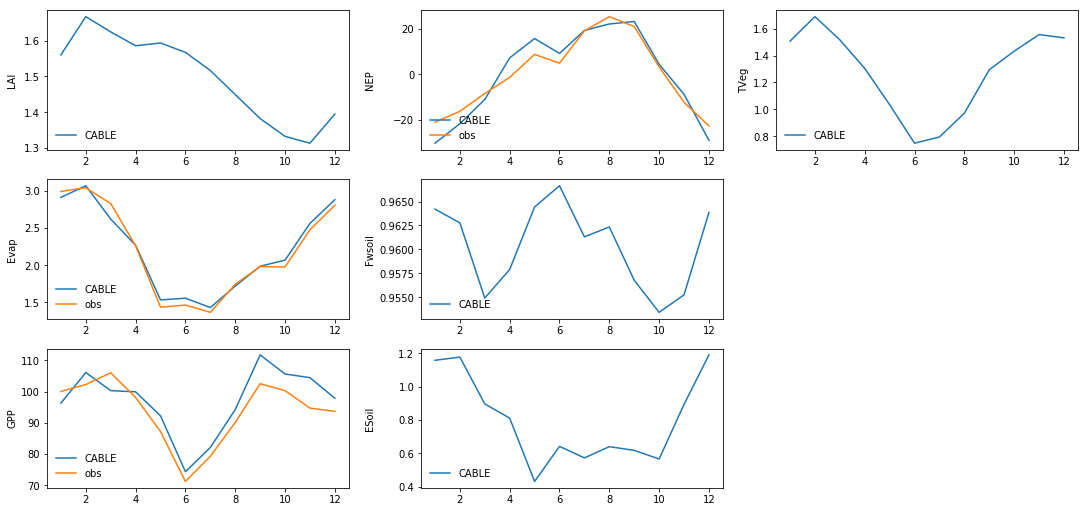

In [50]:
# plot annual cycles of variables
vars = ['LAI','Evap','GPP','NEP','Fwsoil','ESoil','TVeg']
fig=plt.figure(figsize=(15, 7),constrained_layout=True)
npatch_max = 4
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 3
sindex=[]
if (len(vars)%ncols > 0):
    nrows = len(vars)//ncols +1
else:
    nrows = len(vars)//ncols 
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]

x1 = dfm1.index

for index, v in enumerate(vars):
    ax = fig.add_subplot(gs[sindex[index]])
    if v in ['NEP'] :
        y1 = dfm1[v] - dfm1[v].mean()
    else:
        y1 = dfm1[v]
    if v in ['GPP', 'NEP']:
        y1 = y1 * 12 * 1e-6 * 3600 * 24 *30 
    plt.plot(x1,y1,label="CABLE")
    if v in dfobsm.columns:
        if v in ['NEP'] :
            y2 = dfobsm[v] - dfobsm[v].mean()
        else:
            y2 = dfobsm[v]
        if v in ['GPP', 'NEP']:
            y2 = y2 * 12 * 1e-6 * 3600 * 24 *30 
        print(x1.shape)
        print(y2.shape)
        plt.plot(x1,y2,label="obs")
    ax.set_ylabel(v)       
    plt.legend(fontsize=10,frameon=False,loc=3)

fig.align_labels()  
